# Passwort Generator
Das Projekt hat sich die Erstellung eines Passwort-Generators als Ziel gesetzt. Dabei sollen die zu erstellten Passwörter möglichst denen eines Menschen ähneln. 
Zur Realisierung wurde die RNN-Architektur verwendet. Diese Recurrent Neural Networks ermöglichen es, Voraussagen mittels eines Kontext zu treffen, der durch frühere Inputs entstanden ist. Das Netzwerk verfügt sozusagen über ein Gedächtnis. In der Umsetzung geschieht dies durch die Kombination von Hidden-Layern aus der vorherigen Sequenz mit den Hidden-Layern aus der aktuellen Sequenz. Die vorherigen Hidden-Layer haben damit Einfluß auf den Output der nächsten Sequenz. Dieser Algorithmus wird in einer Schleife abgebildet, bis sämtliche Inputs verarbeitet wurden und der Kontext ersichtlich ist.
Klarer wird dies mit den nachfolgenden Formeln, mit denen das Netzwerk trainiert wird:
Quelle [2]
\begin{align}
\ h_t  = f(W^{hh}h_t-1 + W^{hx} + x_t \\
\ y_t  = softmax(W^Sh_t) \\
\ J^t(\theta)  =\sum_{i=1}^{[V]} (y_{ti}\log(y_{ti}))
\end{align}

Die erste Formel ist dafür da, sich an die Hidden-Layer des vorherigen Durchlaufs zu "erinnern". Dabei wird durch h-1 auf den vorherigen Hidden-Layer zugegriffen. Dies wird kombiniert mit dem aktuellen x, anschließend eine Akivierungsfunktion durchgeführt, am gebräuchlisten sind hierbei der Tangens hyperbolicus oder die Sigmoid-Funktion.
Die zweite Formel kümmert sich um die Voraussage des nächsten Ergebnisses in Form von einer Wahrscheinlichkeitsverteilung. 
Zum Schluss wird in der dritten Formel mittels der Cross-Entropy-Loss-Funktion der Fehler zwischen dem Input und dem Output berechnet.



In [160]:
#Imports
from __future__ import unicode_literals, print_function, division
from io import open
import wget # to download passwordlist
import glob
import os
import random
import numpy as np
import unicodedata
import string
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Auslesen der Passworddatei:

Beim Einlesen der Daten haben wir uns an das Tutorial von Pytorch im Kontext mit RNNs gehalten. Um die Strings verarbeiten zu können, haben wir die Methode aus dem Tutorial übernommen, die die Zeichen in Ascii-Code umwandelt, um eine numerische Darstellung der Passwörter zu erhalten. Weiterhin erfolgt eine Umwandlung zu Tensoren durch One-Hot-Encoding sowohl für die Passwörter als auch für die Targets, damit die Backpropagation angewendet werden kann, um den Loss zu berechnen.

Der Länge der Passwortliste wird noch um eine weitere Stelle erweitert, um einen EOS-Marker (End of sentence) hinzuzufügen.
Wie eingangs erwähnt, werden beim Training sowohl der vorherige als auch der aktuelle Hidden Layer berücksichtigt, eine Verarbeitung findet also in Tupeln statt: 
Beispiel "A1B2":
Schritt 1:(A,1)
Schritt 2:(1,B)
Schritt 3:(B,2)
Schritt 4:(2, EOS)
Mit diesem Marker ist dem Netzwerk bekannt, wann das Ende des Passworts erreicht ist.

In [161]:
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in letters
    )
# Auslesen der Passwortdatei
def readPasswords(filename):
    passwords = []
    with open(filename, 'r', encoding="utf8", errors='ignore') as f:
        for line in f:
            if len(line) > 1:
                passwords.append(line)
    passw = [unicodeToAscii(password) for password in passwords]
    return passw

def convertPasswortToTensor(pw):
    tensor = torch.zeros(len(pw), 1, len_letters)
    for li in range(len(pw)):
        letter = pw[li]
        tensor[li][0][letters.find(letter)] = 1
    if use_cuda:
        tensor = tensor.cuda()
    return tensor

def convertTargetToTensor(password):
    indizes = [letters.find(password[i]) for i in range(1,len(password))]
    indizes.append(len_letters - 1) #EOS - Marker
    indizes = torch.LongTensor(indizes)
    if use_cuda:
        indizes = indizes.cuda()
    return indizes


letters = string.ascii_letters + string.digits + string.punctuation
len_letters = len(letters) + 1 # EOS - Marker

## Einlesen der Passwortlisten

Um unser Projekt möglichst leicht reproduzierbar zu machen, haben wir eine Funktion eingebaut, die automatisch Passwortlisten runterlädt, falls diese noch nicht vorhanden sind. So ist gewährleistet, dass Interessenten, die selbst das Netzwerk trainieren möchten, nicht erst umständlich Passwortlisten runterladen müssen. Die Passwortlisten wurden vorher durch ein Skript von Passwörtern gereinigt, die Zeichen enthielten, die nicht UTF-8 -kompatibel waren, da diese Passwörter beim Einlesen Fehler erzeugt haben. Zusammen kommen wir auf ungefähr 83 Millionen Passwörter, die wir für das Training des Netzwerks verwenden könnten.

In [162]:
urls = ['https://www.scrapmaker.com/data/wordlists/dictionaries/rockyou.txt',
        'https://www.scrapmaker.com/download/data/wordlists/passwords/thelist.txt']

filelist = []
passwords = []

# exist files
dirs = os.listdir()
for file in dirs:
    if file.endswith(".txt"):
        filelist.append(file)

for url in urls:
    file = url.split("/")[-1]
    #download files if not exists
    if file not in filelist:
        wget.download(url)
        print('\nsuccessful downloaded ', url)
    #read file and append to passwordlist
    passwords += readPasswords(file)
    print('successful read', file)
    print('total passswords in list: ', len(passwords))

#entfernen von leeren Zeilen
passwords = [passw for passw in passwords if passw != '']

successful read rockyou.txt
total passswords in list:  14344384
successful read thelist.txt
total passswords in list:  32310169


### Aktivierungsfunktionen
Die hier aufgeführten Aktivierungsfunktionen werden mit dem init des Models erzeugt und können beliebig im Forward-Path verwendet werden.
    nn.LogSoftmax() - 
    nn.LeakyReLU() - 
    nn.LogSigmoid() -
    nn.Tanh() - 
## Generatorklasse:

In der Generatorklasse werden die grundlegenden Funktionen und Variablen festgelegt, mit denen das RNN initialisert und ausgeführt werden kann. Der Aufbau ist auch hier stark an die Vorlage aus dem Pytorch-Grundlage angelehnt, da diese leicht verständlich und dem theoretischen Prinzip eines RNN am ehesten entsprach. Allerdings haben wir, wie bereits in unserem Exposé beschrieben, andere Aktivierungsfunktionen eingefügt, die beliebig ausgetauscht werden können, um die, je nach Aktivierungsfunktion, entstandenen Ergebnisse vergleichen zu können. Auf diesem Wege können die Auswirkungen der verschiedenen Aktivierungsfunktionen besser begutachtet werden. Auch haben wir uns an den Vorlesungen orientiert und ein Dropout eingefügt, welcher besagt, wie hoch der Prozentsatz der inaktiven Neuronen pro Durchlauf sein soll. Auch hier bietet sich ein Verändern des Parameters an, um die Auswirkungen an den erstellten Passwörtern des Neuronalen Netzes zu beobachten.

In [163]:
#https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
class PasswordGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PasswordGenerator, self).__init__()
        self.hidden = hidden_size
        self.input2hidden = nn.Linear(input_size + hidden_size, hidden_size, bias=True)
        self.input2output = nn.Linear(input_size + hidden_size, output_size, bias=True)
        self.output2output = nn.Linear(hidden_size +  output_size, output_size, bias=True)        
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.LogSigmoid()
        self.tanh = nn.Tanh()
        
        
    def forward(self, input, hidden):
        combined_input = torch.cat((input, hidden), dim=1)
        hidden = self.input2hidden(combined_input)
        hidden = self.sigmoid(hidden)
        output = self.input2output(combined_input)
        output = self.relu(output)
        combined_output = torch.cat((hidden, output), dim=1)
        output = self. output2output(combined_output)        
        output = self.dropout(output)
        output = self.softmax(output)
        #output = self.sigmoid(output)
        
        return hidden, output

    def initHidden(self):
        return torch.zeros(1, self.hidden)

## CUDA einrichten
Um das Training nicht auf der CPU sondern im schnelleren GPU durchzuführen, haben wir CUDA (Compute Unified Device Architecture) aktiviert. CUDA ist eine von Nvidia entwickelte Programmier-Technik, mit der Programmteile durch den Grafikprozessor (GPU) abgearbeitet werden können. <br>
Im folgenden wird geprüft ob CUDA aktiviert werden kann und eine entsprechende Vairable gesetzt. Wenn CUDA Verfügbar ist, werden im weiteren Code die Tensoren und das Model in den GPU geschrieben. <br>
Eine Verbesserung, die wir jedoch Zeitlich nicht mehr geschafft haben, ist die Einbindung von Multiprocessing um mehrere Prozesse im GPU zu erzeugen und ein schnelleres Training zu ermöglichen.

In [164]:
torch.cuda.init() # Does nothing if the CUDA state is already initialized.
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('CUDA activated')
    #FloatTensor = torch.cuda.FloatTensor
    #LongTensor = torch.cuda.LongTensor
    #torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    device = torch.device(torch.cuda.current_device())

CUDA activated
GeForce GTX 1080


### Loss Funktionen
    nn.BCELoss() - Binary Cross Entropy
    nn.BCEWithLogitsLoss() - This loss combines a Sigmoid layer and the BCELoss in one single class
    nn.NLLLoss() - negative log likelihood loss
    nn.CrossEntropyLoss() - combines nn.LogSoftmax() and nn.NLLLoss() in one single class
    
## Training:

Beim Training definieren wir unser Model, in dem wir die Inputgröße, die Anzahl der Hidden Layers und die Größe des Outputs angeben.
Durch die Bindung der Loss-Function an einen Parameter lassen sich auch hier bequem andere Loss-Functions testen, um die Auswirkungen dieser auf den Trainingsprozess zu beobachten.<br>
Aus Tutorials haben wir erfahren, dass die Methode zero_grad() unbedingt in der Trainingsmethode vorhanden sein muss, um den berechneten Fehler nicht zu addieren. Damit wird sichergestellt, dass der Fehler wieder zurückgesetzt wird und neue Werte annehmen kann.
In einer Schleife wird dann der Forward-Pass und die Berechnung des Loss ausgeführt. Nach der Schleife kann der berechnete Fehler zurückgerechnet werden, um die Hyperparameter anzupassen.
Ebenfalls haben wir eine kleine Funktion aus dem Pytorch-Tutorial übernommen, um Plot-Daten aus dem Model zu extrahieren. Die berechneten Loss-Werte werden hier als Funktion geplottet.<br>
In der übergeordneten train() - Methode nehmen wir uns zufällige Passwörter aus der Liste, um mit diesen unser Netz zu trainieren. Diese ausgewählten Passwörter werden dann, wie eingangs erwähnt, zu Tensoren umgewandelt, damit die entsprechenden Methoden zum Training anwendbar sind. Diese Tensoren werden nun trainPasswords() übergeben, um anschließend den Gesamtfehler zu erhalten. <br>
Über den Parameter trainrounds kann bestimmt werden wie viele zufällige Passwörter aus der Liste gezogen werden um damit zu trainieren. Man könnte hier natürlich auch einfach alle Passwörter aus der Liste der Reihe nach durchlaufen lassen, allerdings brauchen 100000 Passworte in unserem Test bereits knapp 4 Stunden. Hier müsste noch die Performance verbessert werden. Daher mussten wir beim Training einen Kompromiss zwischen vernünftigen Ergebnissen und ausreichender Trainingsdauer finden.

In [165]:
model = PasswordGenerator(len_letters, len_letters, len_letters)
if use_cuda:
    model = model.cuda()
loss_fn = nn.CrossEntropyLoss() #define Loss Function
learning_rate = 0.001

def trainPasswords(input, target):
    target.unsqueeze_(-1) # entfernen der letzten Dimension
    hidden = model.initHidden()
    model.zero_grad() # zeroes the gradient buffers of all parameters
    if use_cuda:
        hidden = hidden.cuda()
    loss = 0
    for i in range(input.size()[0]):
        hidden, output = model(input[i], hidden)
        l = loss_fn(output, target[i]) # Compute the loss
        loss += l
    loss.requires_grad_(True) # The autograd package provides automatic differentiation for all operations on Tensors
    loss.backward()
    for p in model.parameters():
        p.data = p.data.add(-learning_rate, p.grad.data)
        
    return output, loss.item() / input.size(0)

def train(trainrounds):
    total_loss = 0
    plots = []
    plot_every = 100
    progress = 0
    c = 0
    
    for j in range(0, trainrounds):
            password = random.choice(passwords)
            #print('picked password:', password)
            input = convertPasswortToTensor(password)
            target = convertTargetToTensor(password)
            output, loss = trainPasswords(input, target)
            total_loss += loss
            
            progress = j / trainrounds * 100
            if (c < round(progress) and round(progress) % 5 == 0) or j == 1:
                #if use_cuda:
                    #print('the current GPU memory occupied by tensors (GB): ', torch.cuda.memory_allocated() / 1024 / 1024)
                c = round(progress)
                print(round(progress), '% made. Loss: ', loss)
            if j % plot_every == 0:
                plots.append(total_loss / plot_every)
                total_loss = 0

    plt.figure()
    plt.plot(plots)

## Sample Password:

In diesem Bereich angekommen, haben wir bereits das Netz vollständig trainiert und können uns Passwörter generieren lassen.
Da, wie Anfangs erklärt, die Hidden Layer der vorherigen Sequenz Einfluß nehmen auf die Hidden Layer der aktuellen Sequenz, bedeutet dies gleichzeitig, dass beim ersten Durchgang kein vorheriger Hidden Layer existiert. Daher geben wir den ersten Input vor, um dessen anschließende Hidden Layers an die nächste Sequenz zu übergeben.
<br>
In der Schleife zur Gewinnung eines Samples wird zunächst das Model initialisiert und durch die Methode topk() wird der Buchstabe mit der höchsten Wahrscheinlichkeit unserem Sample hinzugefügt. <br>
Um einen Unterschied durch das training zu zeigen, wird die sample Methode einmal vor und ein paar mal nach dem Training aufgerufen.

Sampled Password:  *\ppppppppp
0 % made. Loss:  4.663131020285866
5 % made. Loss:  3.8746582667032876
10 % made. Loss:  3.3712545541616588
15 % made. Loss:  3.2487869262695312
20 % made. Loss:  3.695100021362305
25 % made. Loss:  3.4853649139404297
30 % made. Loss:  3.0503942701551647
35 % made. Loss:  3.3517794609069824
40 % made. Loss:  3.2415809631347656
45 % made. Loss:  3.879272143046061
50 % made. Loss:  3.3667319615681968
55 % made. Loss:  3.746443748474121
60 % made. Loss:  3.879858652750651
65 % made. Loss:  3.3346150716145835
70 % made. Loss:  3.680746623447963
75 % made. Loss:  3.652318318684896
80 % made. Loss:  3.002714474995931
85 % made. Loss:  3.0666420459747314
90 % made. Loss:  2.9449148178100586
95 % made. Loss:  3.9586308797200522
100 % made. Loss:  3.608944574991862
Sampled Password 01:  *\ppbbbbbbb
Sampled Password 02:  *\ppcbbbbbb
Sampled Password 03:  *\ppbbbbbbb
Sampled Password 04:  *\ppcbbbbbb
Sampled Password 05:  *\ppcbbbbbb
Sampled Password 06:  *\ppcbbbbb

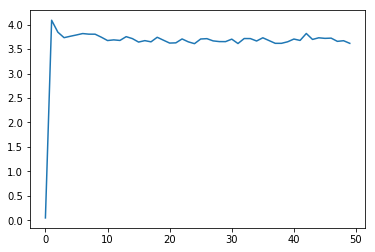

In [166]:
max_chars = 10 # max 10 chars for password

def sample(start_letter='a'):
    with torch.no_grad():  # no need to track history in sampling
        input = convertPasswortToTensor(start_letter)
        hidden = model.initHidden()
        if use_cuda:
            hidden = hidden.cuda()

        output_name = start_letter

        for i in range(max_chars):
            output, hidden = model(input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == len_letters - 1: 
                break
            else:
                letter = letters[topi]
                output_name += letter
            input = convertPasswortToTensor(letter)

        return output_name
#before train
random_start_char = random.choice(letters)
print('Sampled Password: ', sample(random_start_char))

train(100000)

#after train
print('Sampled Password 01: ', sample(random_start_char))
print('Sampled Password 02: ', sample(random_start_char))
print('Sampled Password 03: ', sample(random_start_char))
print('Sampled Password 04: ', sample(random_start_char))
print('Sampled Password 05: ', sample(random_start_char))
print('Sampled Password 06: ', sample(random_start_char))
print('Sampled Password 07: ', sample(random_start_char))
print('Sampled Password 08: ', sample(random_start_char))
print('Sampled Password 09: ', sample(random_start_char))
print('Sampled Password 10: ', sample(random_start_char))

## Quellen

[1] https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html <br>
[2] https://towardsdatascience.com/learn-how-recurrent-neural-networks-work-84e975feaaf7 <br>
[3] https://www.scrapmaker.com/data/wordlists/dictionaries/rockyou.txt <br>
[4] https://www.scrapmaker.com/download/data/wordlists/passwords/thelist.txt <br>
[5] https://arxiv.org/pdf/1308.0850.pdf <br>